In [43]:
import pandas as pd
import numpy as np
import os
from os.path import join
import json

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

from tqdm.notebook import tqdm

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedKFold

In [4]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from nltk.corpus import stopwords

In [5]:
import youtokentome as yttm

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from transformers import BertTokenizer
import torch

In [7]:
from transformers_interpret import SequenceClassificationExplainer
import random
import numpy as np
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, random_split

In [8]:
data_1 = pd.read_csv('data/SPAM text message 20170820 - Data.csv', index_col='Category').rename(columns={'Message':'text'},)
data_2 = pd.read_csv('data/spam.csv', index_col='v1')[['v2']].rename(columns={'v2':'text'})
data_3 = pd.read_csv('data/spam_ham_dataset.csv', index_col='label')[['text']]

In [12]:
data_3.text = data_3.text.apply(lambda x: x.replace('Subject: ', '').replace('\n', ' ').replace('\r', ''))

In [13]:
data = pd.concat([data_1, data_2, data_3]).drop_duplicates()
data.index = pd.Index(map(lambda x: int(x == 'spam'), data.index))
data

,text
0,"Go until jurong point, crazy.. Available only ..."
0,Ok lar... Joking wif u oni...
1,Free entry in 2 a wkly comp to win FA Cup fina...
0,U dun say so early hor... U c already then say...
0,"Nah I don't think he goes to usf, he lives aro..."
...,...
1,slutty milf wants to meet you take that ! ' il...
0,put the 10 on the ft the transport volumes dec...
0,3 / 4 / 2000 and following noms hpl can ' t ta...
0,industrial worksheets for august 2000 activity...


In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [15]:
texts = data.text.values
labels = data.index

In [23]:
input_ids = []
attention_masks = []

for text in tqdm(texts):
    encoded_dict = tokenizer.encode_plus(
                        text,                      
                        add_special_tokens = True, 
                        max_length = 64,           
                        truncation=True,
                        padding='max_length',
                        return_attention_mask = True,   
                        return_tensors = 'pt',    
                   )  
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

/home/stas/venvs/main/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [24]:
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

len(train_dataset), len(val_dataset)

(8617, 2155)

In [25]:
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )


validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size
        )

In [26]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2, 
    output_attentions = False,
    output_hidden_states = False, 
)

model.cuda();

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [27]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8 
                )

In [28]:
epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [29]:
def calc_accuracy(preds, labels):
    return np.sum(preds == labels) / len(labels)

def calc_mcc(preds, labels):
    return matthews_corrcoef(labels, preds)

def print_classification_report(preds, labels):
    print(classification_report(labels, preds))

def plt_confusion_matrix(preds, labels):
    with torch.no_grad():
        gts = np.argmax(preds,axis=1)

        cm = confusion_matrix(labels, gts)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot() 

In [30]:
device = torch.device('cuda:0')

In [31]:
def train_batch(batch, model, optimizer, scheduler):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()        

    output = model(b_input_ids, 
                   token_type_ids=None, 
                   attention_mask=b_input_mask, 
                   labels=b_labels)

    loss = output.loss
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()    
    
    return loss.item()

In [32]:
def eval_model(model, validation_dataloader):
    model.eval() 
    total_eval_loss = 0

    all_labels, all_preds = [], []
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        
            output = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels)

            loss = output.loss
            logits = output.logits

            total_eval_loss += loss.item()

            all_labels.append(b_labels.cpu().numpy())
            all_preds.append(logits.detach().cpu().numpy())



    avg_val_loss = total_eval_loss / len(validation_dataloader)

    all_preds = np.vstack(all_preds)
    all_labels = np.hstack(all_labels)
    
    pred_flat = np.argmax(all_preds, axis=1).flatten()
    labels_flat = all_labels.flatten()
    
    print(np.array(all_preds).shape)
    print(f"  Accuracy: {np.round(calc_accuracy(pred_flat, labels_flat), 4)}")
    print(f"  MCC: {np.round(calc_mcc(pred_flat, labels_flat), 4)}")
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print_classification_report(pred_flat, labels_flat)
    plt_confusion_matrix(all_preds, all_labels)



======== Epoch 1 / 4 ========
Training...




  Average training loss: 0.09
Running Validation...
(2155, 2)
  Accuracy: 0.9805
  MCC: 0.9407
  Validation Loss: 0.06
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1706
           1       0.96      0.95      0.95       449

    accuracy                           0.98      2155
   macro avg       0.97      0.97      0.97      2155
weighted avg       0.98      0.98      0.98      2155


======== Epoch 2 / 4 ========
Training...




  Average training loss: 0.03
Running Validation...
(2155, 2)
  Accuracy: 0.981
  MCC: 0.9427
  Validation Loss: 0.08
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1706
           1       0.95      0.96      0.95       449

    accuracy                           0.98      2155
   macro avg       0.97      0.97      0.97      2155
weighted avg       0.98      0.98      0.98      2155


======== Epoch 3 / 4 ========
Training...




  Average training loss: 0.01
Running Validation...
(2155, 2)
  Accuracy: 0.9828
  MCC: 0.948
  Validation Loss: 0.08
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1706
           1       0.96      0.96      0.96       449

    accuracy                           0.98      2155
   macro avg       0.97      0.97      0.97      2155
weighted avg       0.98      0.98      0.98      2155


======== Epoch 4 / 4 ========
Training...




  Average training loss: 0.00
Running Validation...
(2155, 2)
  Accuracy: 0.9824
  MCC: 0.9463
  Validation Loss: 0.08
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1706
           1       0.97      0.95      0.96       449

    accuracy                           0.98      2155
   macro avg       0.98      0.97      0.97      2155
weighted avg       0.98      0.98      0.98      2155



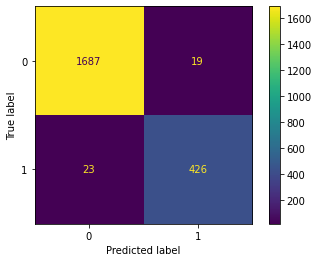

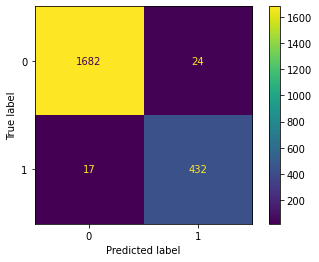

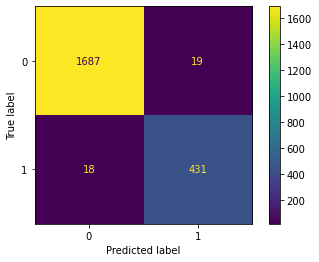

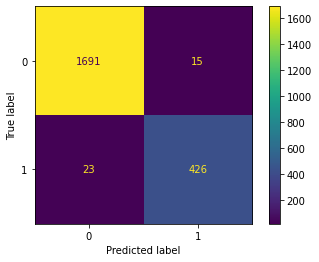

In [35]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
for epoch_i in range(epochs):
    print(f'\n======== Epoch {epoch_i + 1} / {epochs} ========\nTraining...')
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(tqdm(train_dataloader), 1):
        loss = train_batch(batch, model, optimizer, scheduler)
        total_train_loss += loss
    avg_train_loss = total_train_loss / len(train_dataloader)            

    print("\n  Average training loss: {0:.2f}\nRunning Validation...".format(avg_train_loss))
    
    eval_model(model, validation_dataloader)


Вау, трансформеры победили классический мл :)

Однако, давайте попробуем поинтерпретировать причины принятия решения. Сначала кажется, что коль мы имеем дело с трансформерами, давайте посмотрим на attentionы. Однако я не понял, что селф атеншенах берта можно конкретно увидеть, что можно было бы проинтерпретировать как критерии принятия решения моделью (ну либо нужно производить довольно большое исследование как в https://www.topbots.com/bert-secrets/). Поэтому я решил обратить внимание на другую важную вещь в нейросетях -- градиенты. SequenceClassificationExplainer -- буквально инструмент для определения "критериев, по которым модель определяет является ли сообщение спамом или нет"

In [36]:
# смотрим на статистику влияния токенов словаря при обработке предложений разных классов
cls_explainer = SequenceClassificationExplainer(
    model,
    tokenizer)
vocab_stats = {0: {}, 1: {}}
with torch.no_grad():
    for label, tokens in tqdm(zip(labels, input_ids), total=len(data.text)):
        lbl = label.item()
        text = tokenizer.decode(tokens, skip_special_tokens=True)
        word_attributions = cls_explainer(text)
        for token, score in word_attributions:
            vocab_stats[lbl].setdefault(token, [0,0])
            vocab_stats[lbl][token][0] += score
            vocab_stats[lbl][token][1] += 1

In [44]:
with open('vocab_stats.json', 'w') as fp:
    json.dump(vocab_stats, fp)

In [45]:
res_0 = {'token':[], 'mean_attr': [], 'cnt': []}
for token, (attr, cnt) in vocab_stats[0].items():
    res_0['token'].append(token)
    res_0['mean_attr'].append(attr/(cnt + 1e-8))
    res_0['cnt'].append(cnt)
res_0_df = pd.DataFrame(res_0).sort_values('mean_attr', ascending=False)

In [46]:
res_1 = {'token':[], 'mean_attr': [], 'cnt': []}
for token, (attr, cnt) in vocab_stats[1].items():
    res_1['token'].append(token)
    res_1['mean_attr'].append(attr/(cnt + 1e-8))
    res_1['cnt'].append(cnt)
res_1_df = pd.DataFrame(res_1).sort_values('mean_attr', ascending=False)

In [47]:
# какие токены встречались достаточно часто и имели наибольшее влияние в хаме
res_0_df[res_0_df.cnt>10][:20]

,token,mean_attr,cnt
3021,reaching,0.439146,11
1627,feeling,0.409462,25
815,leaving,0.380825,25
284,doing,0.377593,114
612,ave,0.373675,11
174,going,0.356759,252
1667,thinking,0.355892,25
351,seeing,0.340059,14
2530,loving,0.337437,17
777,taking,0.332133,42


In [48]:
# какие токены встречались достаточно часто и имели наибольшее влияние в спаме
res_1_df[res_1_df.cnt>10][:20]

,token,mean_attr,cnt
966,removed,0.580913,25
3892,drug,0.451347,27
2900,market,0.387638,32
4349,million,0.381769,18
2637,popular,0.379222,25
1203,cheap,0.373137,80
142,000,0.353097,90
2471,site,0.349938,61
132,##00,0.343172,192
3489,anti,0.328502,17


Результаты по содержанию отличаются от классических методов (хотя пока я изучал работу, некоторые одинаковые токены появлялись), однако здесь также прослеживается соотвествие интуитивным представлениям о спаме -- в спамовых сообщениях явно говорится о деньгах, наркотиках, порно и тд. В неспаме видим что представлены слова без какой-то яркой окраски (и заметно кстати, что глаголы более популярны)